In [14]:
import numpy as np
from test_utils import *

def construct_data(N, C):
    spectra, _ = load_data()

    s1 = signif_features(spectra[0], N)

    s2 = signif_features(spectra[1], N)

    s1a = np.array([p for _, p in s1.confs])
    s12b = np.array([p for _, p in s1.confs])
    s1_idx = np.argsort(s1a)[:N//2]
    s12b[s1_idx] = 0

    s2a = np.array([p for _, p in s2.confs])
    s22b = np.array([p for _, p in s2.confs])
    s2_idx = np.argsort(s2a)[:N//2]
    s22b[s2_idx] = 0

    s1v = np.array([v for v, _ in s1.confs])
    s2v = np.array([v for v, _ in s2.confs])

    M1 = multidiagonal_cost(s1v, s1v, C)
    G01 = warmstart_sparse(s1a, s12b, C)

    M2 = multidiagonal_cost(s2v, s2v, C)
    G02 = warmstart_sparse(s2a, s22b, C)

    c = reg_distribiution(N, C)

    return s1a, s12b, s2a, s22b, c, M1, G01, M2, G02

regm1: 100%|██████████| 5/5 [09:02<00:00, 108.45s/it]


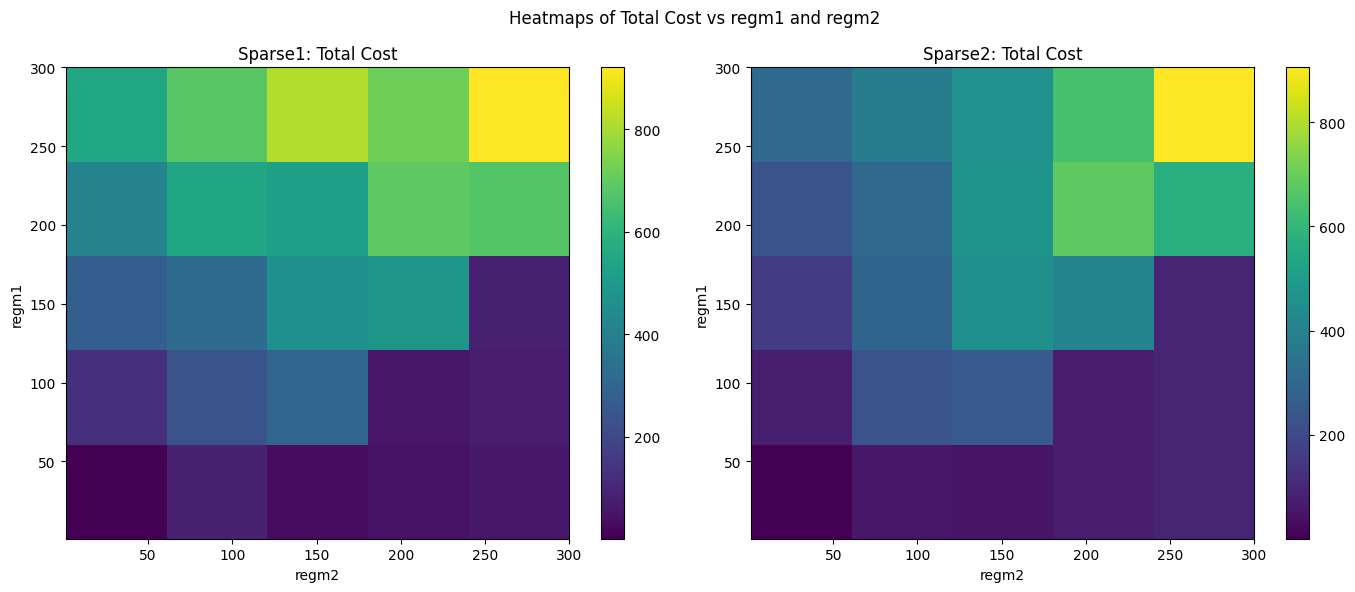

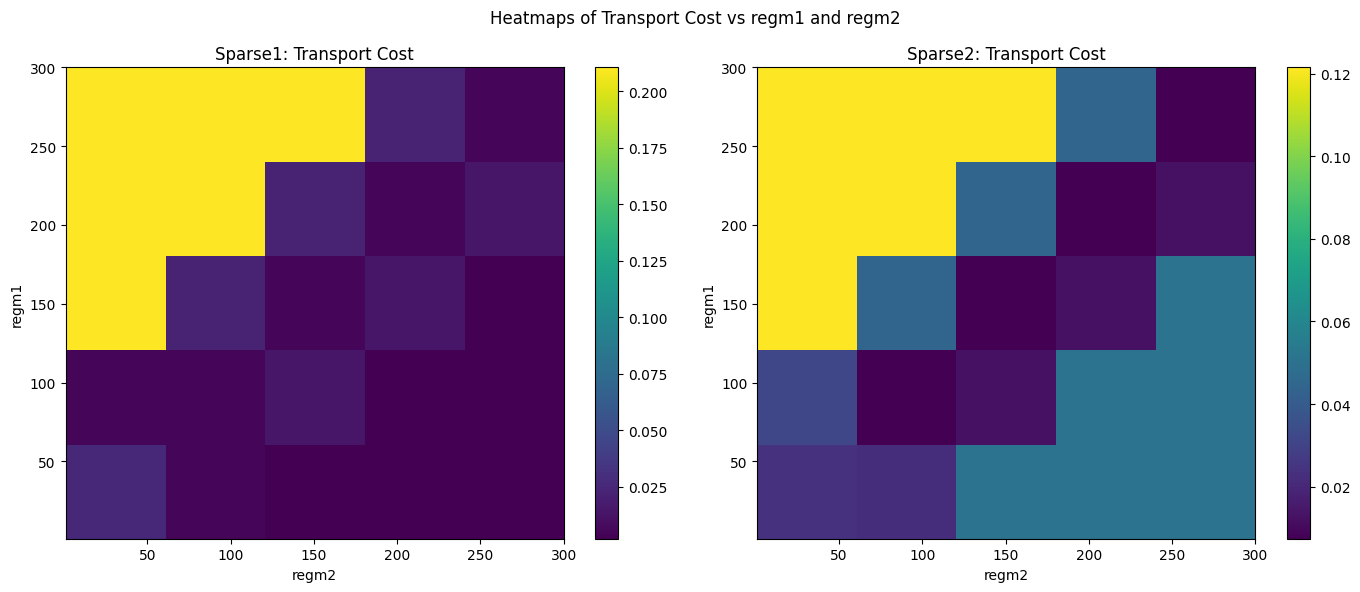

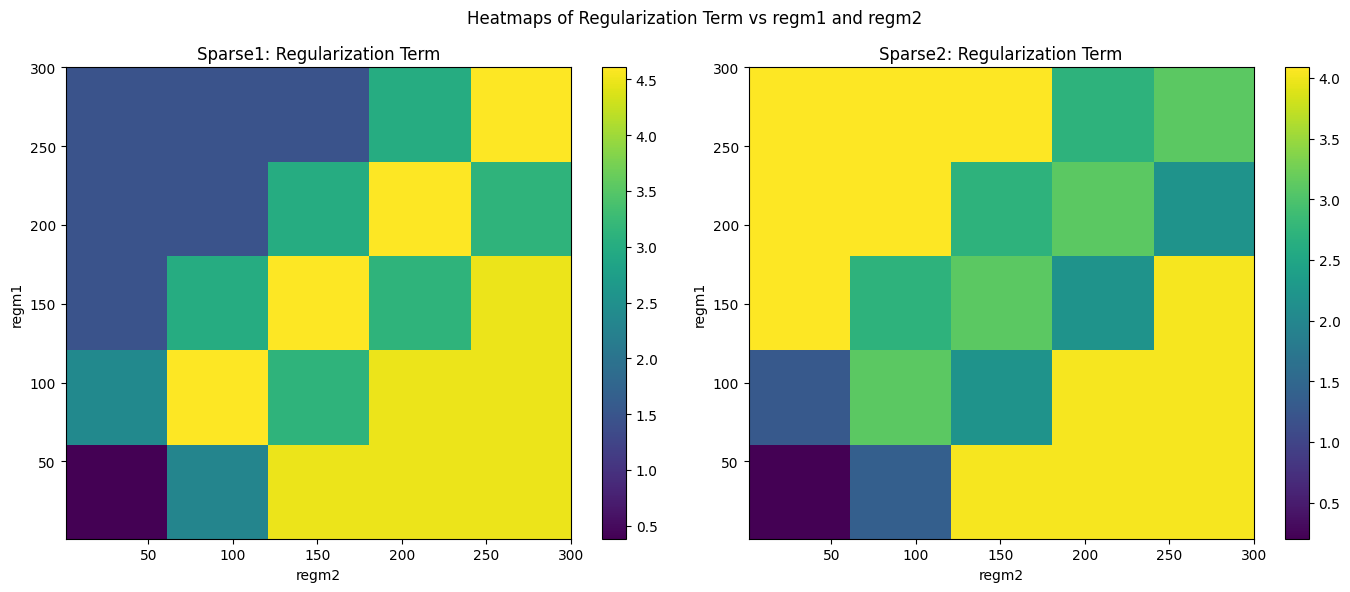

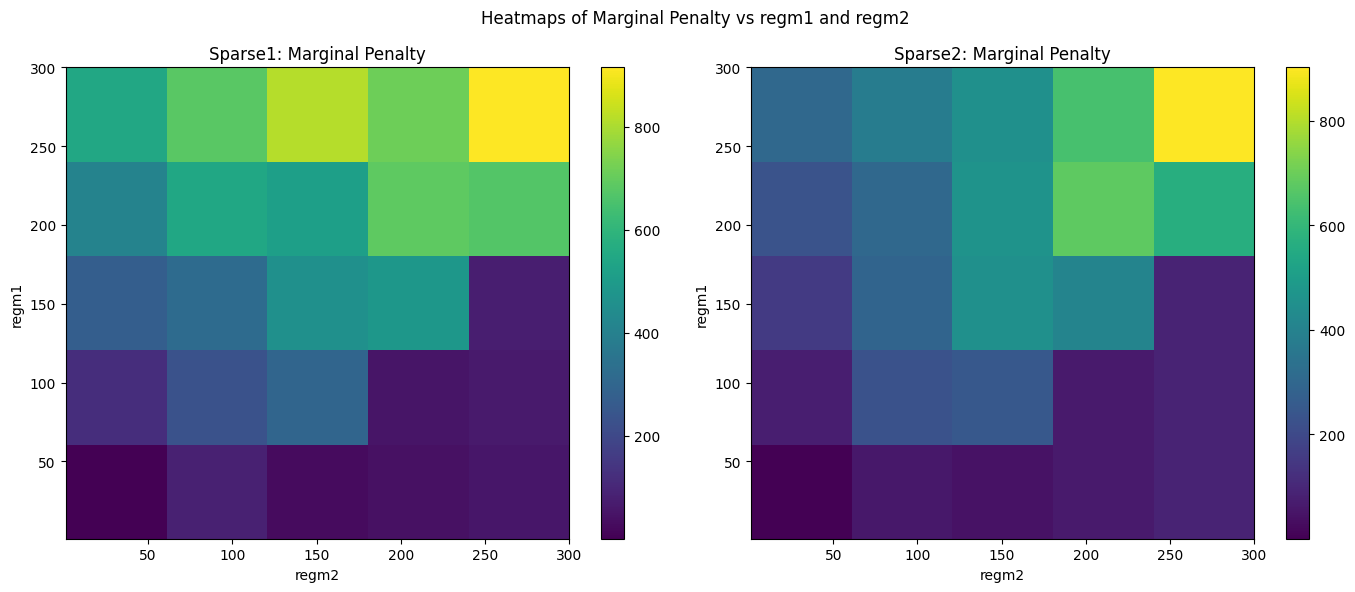

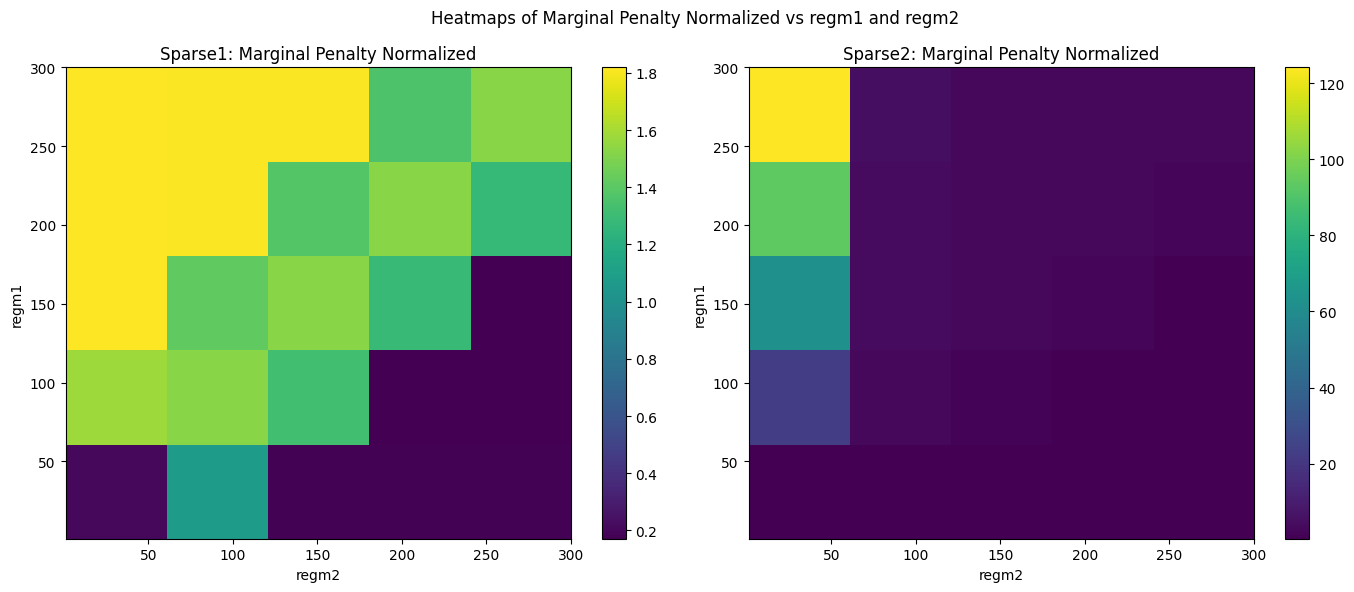

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- PARAMETERS ---
regm1_values = np.linspace(1, 300, num=5)
regm2_values = np.linspace(1, 300, num=5)
reg = 1.5
N = 500
C = 25
max_iter = 1000

# --- DATA PREP ---
s1a, s12b, s2a, s22b, c, M1, G01, M2, G02 = construct_data(N, C)

# --- METRIC MATRICES ---
shape = (len(regm1_values), len(regm2_values))
def new_grid(): return np.zeros(shape)

metrics_s1 = {
    "Total Cost": new_grid(),
    "Transport Cost": new_grid(),
    "Regularization Term": new_grid(),
    "Marginal Penalty": new_grid(),
    "Marginal Penalty Normalized": new_grid()
}
metrics_s2 = {k: new_grid() for k in metrics_s1}

# --- MAIN LOOP ---
for i, regm1 in enumerate(tqdm(regm1_values, desc="regm1")):
    for j, regm2 in enumerate(regm2_values):
        sparse1 = UtilsSparse(s1a, s12b, c, G01, M1, reg, regm1, regm2)
        sparse2 = UtilsSparse(s2a, s22b, c, G02, M2, reg, regm1, regm2)

        G1, _ = sparse1.mirror_descent_unbalanced(numItermax=max_iter)
        G2, _ = sparse2.mirror_descent_unbalanced(numItermax=max_iter)

        # Sparse1
        tc1 = sparse1.sparse_dot(G1, sparse1.offsets)
        reg1 = sparse1.reg_kl_sparse(G1, sparse1.offsets)
        marg1 = sparse1.marg_tv_sparse(G1, sparse1.offsets)

        metrics_s1["Total Cost"][i, j] = tc1 + reg1 + marg1
        metrics_s1["Transport Cost"][i, j] = tc1
        metrics_s1["Regularization Term"][i, j] = reg1
        metrics_s1["Marginal Penalty"][i, j] = marg1
        metrics_s1["Marginal Penalty Normalized"][i, j] = marg1 / (regm1 + regm2)

        # Sparse2
        tc2 = sparse2.sparse_dot(G2, sparse2.offsets)
        reg2 = sparse2.reg_kl_sparse(G2, sparse2.offsets)
        marg2 = sparse2.marg_tv_sparse(G2, sparse2.offsets)

        metrics_s2["Total Cost"][i, j] = tc2 + reg2 + marg2
        metrics_s2["Transport Cost"][i, j] = tc2
        metrics_s2["Regularization Term"][i, j] = reg2
        metrics_s2["Marginal Penalty"][i, j] = marg2
        metrics_s2["Marginal Penalty Normalized"][i, j] = marg2 / (reg1 + regm2)

# --- HEATMAP FUNCTION ---
def plot_heatmap_grid(metric_name, data_s1, data_s2, xvals, yvals):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    extent = [xvals[0], xvals[-1], yvals[0], yvals[-1]]

    im1 = axes[0].imshow(data_s1, origin='lower', aspect='auto', extent=extent)
    axes[0].set_title(f"Sparse1: {metric_name}")
    axes[0].set_xlabel("regm2")
    axes[0].set_ylabel("regm1")
    plt.colorbar(im1, ax=axes[0])

    im2 = axes[1].imshow(data_s2, origin='lower', aspect='auto', extent=extent)
    axes[1].set_title(f"Sparse2: {metric_name}")
    axes[1].set_xlabel("regm2")
    axes[1].set_ylabel("regm1")
    plt.colorbar(im2, ax=axes[1])

    plt.suptitle(f"Heatmaps of {metric_name} vs regm1 and regm2")
    plt.tight_layout()
    plt.show()

# --- PLOT ALL METRICS ---
for metric in metrics_s1.keys():
    plot_heatmap_grid(metric, metrics_s1[metric], metrics_s2[metric], regm2_values, regm1_values)
